# training

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL
import IPython.display as display

In [ ]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
train_images = train_images / 255.0
test_images = test_images / 255.0

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10)])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 64)                50240     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 10)                650       
                                                                 
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.fit(train_images, train_labels, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 15s 6ms/step - loss: 0.2779 - accuracy: 0.9198
Epoch 2/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1268 - accuracy: 0.9619
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0915 - accuracy: 0.9718
Epoch 4/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0730 - accuracy: 0.9776
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0583 - accuracy: 0.9810
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0496 - accuracy: 0.9839
Epoch 7/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0434 - accuracy: 0.9863
Epoch 8/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0352 - accuracy: 0.9883
Epoch 9/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0317 - accuracy: 0.9893
Epoch 10/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.02

In [ ]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
test_acc

313/313 - 1s - loss: 0.1016 - accuracy: 0.9739 - 955ms/epoch - 3ms/step


0.9739000201225281

# visualizing dense_1, neuron 32 with optimization

In [ ]:
dream_model = tf.keras.models.Model(inputs=model.input, outputs=model.get_layer('dense_1').output)

optimization objective: maximize activation of dense_1, neuron 32

In [ ]:
def calc_loss_neuron(img, model):
  img_batch = tf.expand_dims(img, axis=0)
  dense_1_acts = dream_model(img_batch)
  act = dense_1_acts[0][32]
  return tf.convert_to_tensor(act)

In [ ]:
def calc_loss_layer(img, model):
# Pass forward the image through the model to retrieve the activations.
# Converts the image into a batch of size 1.
  img_batch = tf.expand_dims(img, axis=0)
  layer_activations = model(img_batch)
  if len(layer_activations) == 1:
    layer_activations = [layer_activations]

  losses = []
  for act in layer_activations:
    loss = tf.math.reduce_mean(act)
    losses.append(loss)
    
    return  tf.reduce_sum(losses)

In [ ]:
# Normalize an image
def deprocess(img):
  img = 255*(img + 1.0)/2.0
  return tf.cast(img, tf.uint8)

# Display an image
def show(img):
  display.display(PIL.Image.fromarray(np.array(img)))

deepdream

In [ ]:
def DeepDream(dream_model, img, steps=100, step_size=0.01):
  # img is np array with shape (1,28,28), normalized
  step_size = tf.convert_to_tensor(step_size)
  steps_remaining = steps
  step = 0
  while steps_remaining:
    if steps_remaining > 100:
      run_steps = tf.constant(100)
    else:
      run_steps = tf.constant(steps_remaining)
    steps_remaining -= run_steps
    step += run_steps

    for n in tf.range(steps):
      with tf.GradientTape() as tape:
        tape.watch(img)
        loss = calc_loss_neuron(img, dream_model)
      gradients = tape.gradient(loss, img)
      gradients /= tf.math.reduce_std(gradients) + 1e-8 # normalize the gradients
      
      img = img + gradients * step_size
      img = tf.clip_by_value(img, -1, 1) 
    
    display.clear_output(wait=True)
    show(deprocess(img))
    print('step {}, loss {}'.format(step, loss))
  
  result = deprocess(img)
  display.clear_output(wait=True)
  plt.figure()
  plt.imshow(result)

random input:

In [ ]:
noise = tf.random.uniform((28,28)) / 255.0

optimizing for maximal neuron activation:

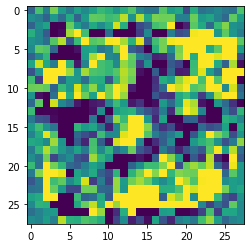

In [ ]:
DeepDream(dream_model, noise)

optimizing for maximal layer activation:

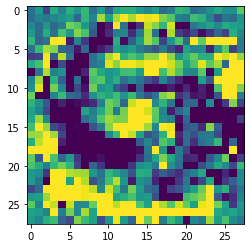

In [ ]:
DeepDream(dream_model, noise)